In [1]:
import numpy as np
import torch
from scipy import stats
from torch.autograd import Variable
import sys, inspect
sys.path.insert(0, '..')

%matplotlib inline
import pymc
import matplotlib.pyplot as plt

from learn_smc_proposals import cde
from learn_smc_proposals.examples import multilevel_poisson

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

Couldn't import dot_parser, loading of dot files will not be possible.


# Learn a multilevel model

We're going to learn the model for the PUMPS data:

http://www.openbugs.net/Examples/Pumps.html

This model has local parameters $\theta_i$ and global parameters $\alpha, \beta$.

In [2]:
theta_est, params_est = multilevel_poisson.get_estimators()
theta_est.load_state_dict(torch.load('../saved/trained_poisson_theta.rar'))
params_est.load_state_dict(torch.load('../saved/trained_poisson_params.rar'))

In [3]:
true_t = np.array([94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5])
true_x = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])

### Training; synthetic data

We can use our model to define synthetic data, which we will use to train the inference network.

Each "minibatch" will be an unconditioned sample from the graphical model.

Values on true data, as reported in the George et al. (1993) are:
    
    theta = [0.060 0.102 0.089 0.116 0.602 0.609 0.891 0.894 1.588 1.994 ]
    alpha = 0.7 
    beta = 0.9 
    
We'll run MCMC here to get benchmark estimates of the posterior distributions.

In [4]:
real_data = Variable(torch.FloatTensor(np.vstack((true_x, true_t)).T))

In [5]:
M_train = pymc.Model(multilevel_poisson.gamma_poisson(None,None))
M_test = pymc.Model(multilevel_poisson.gamma_poisson(true_x, true_t))

In [6]:
def estimate_MCMC(data_x, data_t, ns, iters=10000, burn=0.5):
    """ MCMC estimate of weight distribution """
    mcmc_est = pymc.MCMC(multilevel_poisson.gamma_poisson(data_x, data_t))
    mcmc_est.sample(iters, burn=burn*iters, thin=np.ceil(burn*iters/ns))
    trace_theta = mcmc_est.trace('theta').gettrace()[:ns]
    trace_alpha = mcmc_est.trace('alpha').gettrace()[:ns]
    trace_beta = mcmc_est.trace('beta').gettrace()[:ns]
    return trace_theta, trace_alpha, trace_beta

In [7]:
mcmc_theta, mcmc_alpha, mcmc_beta = estimate_MCMC(true_x, true_t, ns=1000, iters=500000)
# print "MCMC MSE", np.mean((mcmc_theta.mean(0) - true_theta)**2)

true_alpha = mcmc_alpha.mean()
true_beta = mcmc_beta.mean()
true_theta = mcmc_theta.mean(0)

print "\n\nMCMC Estimated theta:", true_theta.round(3)
print "\nMCMC Estimated (alpha, beta):", true_alpha.round(3), true_beta.round(3)

 [-----------------100%-----------------] 500000 of 500000 complete in 69.2 sec

MCMC Estimated theta: [ 0.059  0.101  0.09   0.115  0.517  0.56   1.168  0.794  1.731  1.909]

MCMC Estimated (alpha, beta): 0.683 0.905


## Comparison: samples from the proposal, and the MCMC posterior

In [8]:
def draw_inverse(ns=100):
    tmp = theta_est.sample(real_data, ns=ns).squeeze(2)
    samples = params_est.sample(tmp, ns=1)
    return tmp.cpu().data.numpy(), samples.cpu().data.numpy()

In [9]:
nn_raw_theta, nn_raw_params = draw_inverse(1000)

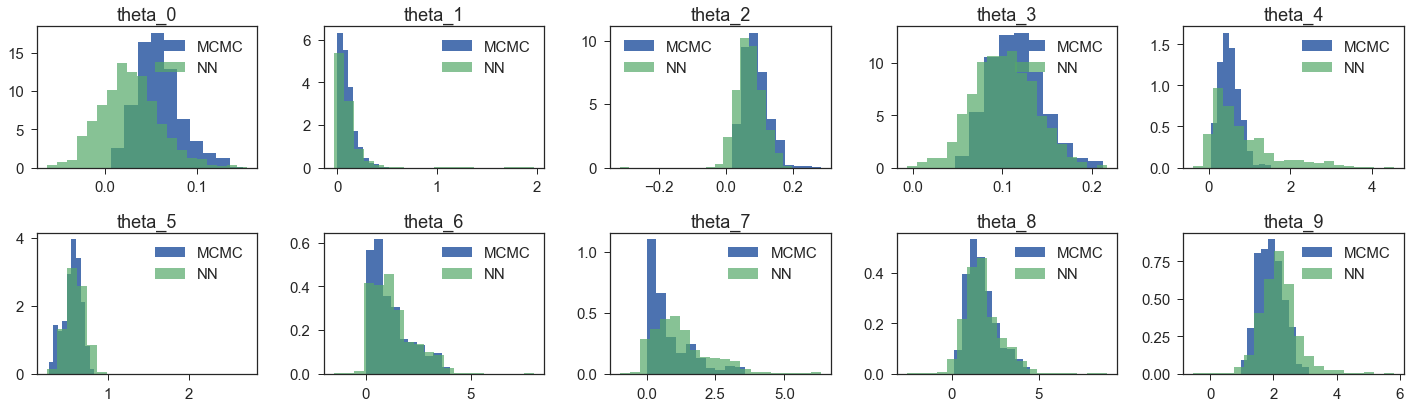

In [10]:
plt.figure(figsize=(20,6))
for i in xrange(10):
    plt.subplot(2,5,i+1)
    plt.hist(mcmc_theta[:,i], normed=True);
    plt.hist(nn_raw_theta[:,i], alpha=0.7, normed=True, bins=20);
    plt.title("theta_"+str(i))
    plt.legend(['MCMC', 'NN'])
    
plt.tight_layout()

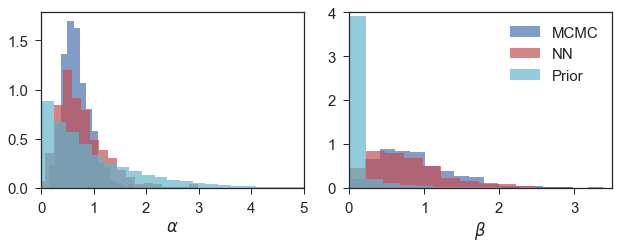

In [11]:
bins = 20
a = .7

plt.figure(figsize=(9,3.75))
plt.subplot(121)
plt.hist(mcmc_alpha, normed=True, bins=bins, color=sns.color_palette()[0], histtype='stepfilled', linewidth=2.0, alpha=a);
plt.hist(nn_raw_params[:,0], color=sns.color_palette()[2], normed=True, bins=bins, histtype='stepfilled', linewidth=2.0, alpha=a);
# plt.hist(nn_raw_samples[:,0], normed=True, bins=bins, histtype='step', linewidth=2.0);
plt.hist(stats.expon(scale=1.0).rvs(10000), color=sns.color_palette()[5], normed=True, bins=2*bins, histtype='stepfilled', linewidth=2.0, alpha=a);
plt.xlim((0,5))
# plt.xlim((0,plt.xlim()[1]))
plt.xlabel("$\\alpha$")
plt.subplot(122)
plt.hist(mcmc_beta, normed=True, bins=bins, color=sns.color_palette()[0], histtype='stepfilled', linewidth=2.0, alpha=a);
# plt.hist(nn_raw_samples[:,1], normed=True, bins=bins, histtype='step', linewidth=2.0);
plt.hist(nn_raw_params[:,1], normed=True, color=sns.color_palette()[2], bins=bins, histtype='stepfilled', linewidth=2.0, alpha=a);
plt.hist(stats.gamma(a=0.1, scale=1.0).rvs(10000), color=sns.color_palette()[5], normed=True, bins=2*bins, histtype='stepfilled', linewidth=2.0, alpha=a);
plt.xlim((0,3.5))
# plt.xlim((0,plt.xlim()[1]))
plt.ylim(0,4)
plt.legend(['MCMC', 'NN', 'Prior'])
plt.xlabel("$\\beta$")
plt.tight_layout()
# plt.savefig("poisson-params-alt.pdf")

## Simple benchmark: likelihood weighting

Using the prior as a proposal, relative to using the learned network, what do we gain in terms of effective sample size?

In [12]:
def bootstrap_propose(model):
    success = False
    while success == False:
        try:
            model.alpha.rand()
            model.beta.rand()
            model.theta.rand()
            success = True
        except:
            pass
    try:
        weight = model.x.logp
    except:
        weight = -np.Inf
    return weight

def bootstrap_IS(model, ns=100):
    theta = np.empty((ns,10))
    params = np.empty((ns,2))
    log_w = np.empty((ns,))
    for n in xrange(ns):
        log_w[n] = bootstrap_propose(model)
        theta[n] = model.theta.value
        params[n] = [model.alpha.value, model.beta.value]
    return theta, params, log_w

def normalize_log_weights(log_w):
    safe_log_w = np.array(log_w)
    safe_log_w[np.isnan(log_w)] = np.NINF
    A = safe_log_w.max()
    log_denom = np.log(np.sum(np.exp(safe_log_w - A))) + A
    return np.exp(safe_log_w - log_denom)

def systematic_resample(weights):
    ns = len(weights)
    cdf = np.cumsum(weights)
    cutoff = (np.random.rand() + np.arange(ns))/ns
    return np.digitize(cutoff, cdf)

In [13]:
def nn_IS(model, ns=100):
    # theta
    theta, log_q = theta_est.propose(real_data, ns=ns)
    theta = theta.data.cpu().numpy().squeeze(2)
    log_w = -log_q.data.cpu().numpy().sum(1)
    # alpha, beta
    params, log_q = params_est.propose(Variable(torch.Tensor(theta)))
    alpha = params.data.cpu().numpy()[:,0] #np.empty((ns,))
    beta = params.data.cpu().numpy()[:,1] # np.empty((ns,))
    log_w -= log_q.data.cpu().numpy().squeeze(1)
    # likelihood
    log_w += stats.poisson(model.t.value * theta).logpmf(model.x.value).sum(1)
    log_w += stats.gamma(a=alpha[:,None], scale=1.0/beta[:,None]).logpdf(theta).sum(1)
    log_w += stats.expon(scale=1.0).logpdf(alpha)
    log_w += stats.gamma(a=0.1, scale=1.0).logpdf(beta)
    log_w[np.isnan(log_w)] = np.NINF
    return theta, params.data.cpu().numpy(), log_w

In [14]:
nn_theta,nn_params,nn_log_w = nn_IS(M_test, ns=10000)

In [15]:
boostrap_theta,bootstrap_params,bootstrap_log_w = bootstrap_IS(M_test, ns=10000)

In [16]:
print "Effective sample size (benchmark):", 1.0/np.sum(normalize_log_weights(bootstrap_log_w)**2)
print "Effective sample size (NN):", 1.0/np.sum(normalize_log_weights(nn_log_w)**2)

Effective sample size (benchmark): 1.00000175273
Effective sample size (NN): 323.396998175


### Define a method for running divide-and-conquer SMC

This algorithm first proposes values across all thetas, then resamples prior to proposing alpha and beta.

In [17]:
def run_DCSMC(model, ns=100, return_extras=False):
    # stage one
    num_points = 10
    theta, log_q = theta_est.propose(real_data, ns=ns)
    theta = theta.data.cpu().numpy().squeeze(2)
    log_w = -log_q.data.cpu().numpy()
    
    log_w += stats.poisson(model.t.value * theta).logpmf(model.x.value)
    
    log_w[np.isnan(log_w)] = np.NINF
    
    Z_est = np.log(np.exp(log_w).mean(0))
    
#     print Z_est
    
    for i in xrange(num_points):
        indices = systematic_resample(normalize_log_weights(log_w[:,i]))
        np.random.shuffle(indices)
        theta[:,i] = theta[indices,i]

    # Now: we have unweighted samples for each theta[:,i]
    # ... and we have Z estimates for each i. What is next?
    
    # Sample values of alpha, beta
    params, log_q = params_est.propose(Variable(torch.Tensor(theta)))
    alpha = params.data.cpu().numpy()[:,0] #np.empty((ns,))
    beta = params.data.cpu().numpy()[:,1] # np.empty((ns,))
    log_w = -log_q.data.cpu().numpy().squeeze(1)
    
    # Merge
    tmp = stats.gamma(a=alpha[:,None], scale=1.0/beta[:,None])
    log_w += tmp.logpdf(theta).sum(1)
    log_w += stats.expon(scale=1.0).logpdf(alpha)
    log_w += stats.gamma(a=0.1, scale=1.0).logpdf(beta)
    
    assert(log_w.shape == (ns,))
    
    indices = systematic_resample(normalize_log_weights(log_w))
    
    log_w[np.isnan(log_w)] = np.NINF
    
    Z_est = Z_est.sum() + np.log(np.exp(log_w).mean())
    
    if return_extras:
        alpha_orig = np.array(alpha)
        beta_orig = np.array(beta)
    
    alpha = alpha[indices]
    beta = beta[indices]
    theta = theta[indices]
    
    if return_extras:
        return theta, alpha, beta, Z_est, alpha_orig, beta_orig
    else:
        return theta, alpha, beta, Z_est

# Compare importance sampling with NN proposals, proposals from prior, and divide-and-conquer SMC with NN proposals

In [18]:
sizes = [5, 10, 50, 100, 500, 1000, 5000, 10000]

replications = 10

In [19]:
dcsmc_results_Z = np.empty((replications, len(sizes)))
dcsmc_results_L2 = np.empty((replications, len(sizes)))

for c, size in enumerate(sizes):
    for rep in xrange(replications):
        tmp_theta, tmp_alpha, tmp_beta, Z_est = run_DCSMC(M_test, size)

        dcsmc_results_L2[rep,c] = np.sqrt(np.mean((tmp_theta.mean(0) - true_theta)**2))
        dcsmc_results_Z[rep,c] = Z_est

In [20]:
lwis_results_Z = np.empty((replications, len(sizes)))
lwis_results_L2 = np.empty((replications, len(sizes)))

for c, size in enumerate(sizes):
    for rep in xrange(replications):
        bootstrap_theta, _, bootstrap_log_w = bootstrap_IS(M_test, ns=size)
        Z_est = np.log(np.exp(bootstrap_log_w).mean())
        mean_est = np.dot(bootstrap_theta.T, normalize_log_weights(bootstrap_log_w))
        lwis_results_L2[rep,c] = np.sqrt(np.mean((mean_est - true_theta)**2))
        lwis_results_Z[rep,c] = Z_est


/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


In [21]:
nnis_results_Z = np.empty((replications, len(sizes)))
nnis_results_L2 = np.empty((replications, len(sizes)))

for c, size in enumerate(sizes):
    for rep in xrange(replications):
        nnis_theta, _, nnis_log_w = nn_IS(M_test, ns=size)
        Z_est = np.log(np.exp(nnis_log_w).mean())
        mean_est = np.dot(nnis_theta.T, normalize_log_weights(nnis_log_w))
        nnis_results_L2[rep,c] = np.sqrt(np.mean((mean_est - true_theta)**2))
        nnis_results_Z[rep,c] = Z_est


/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1304: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


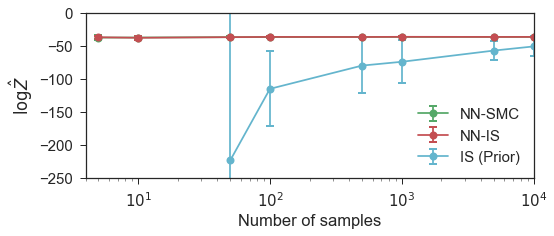

In [22]:
plt.figure(figsize=(8,3.6))

def get_res(res):
    filtered = np.array(res)
    return np.nanmean(filtered, 0), np.nanstd(filtered, 0)

tmp_m, tmp_s = get_res(dcsmc_results_Z) 
plt.errorbar(sizes, tmp_m, 2*tmp_s,marker='.', capsize=4, markeredgewidth=2, color=sns.color_palette()[1])

tmp_m, tmp_s = get_res(nnis_results_Z)
plt.errorbar(sizes, tmp_m, 2*tmp_s,marker='.', capsize=4, markeredgewidth=2, color=sns.color_palette()[2])

tmp_m, tmp_s = get_res(lwis_results_Z) 
plt.errorbar(sizes, tmp_m, 2*tmp_s,marker='.', capsize=4, markeredgewidth=2, zorder=0,color=sns.color_palette()[5])


plt.legend(['NN-SMC', 'NN-IS', 'IS (Prior)'], loc='lower right')


plt.semilogx();

plt.xlim(sizes[0]-1, sizes[-1])
plt.ylim([-250, 0])

plt.ylabel("$\log \hat Z$")
plt.xlabel("Number of samples")
plt.tight_layout()

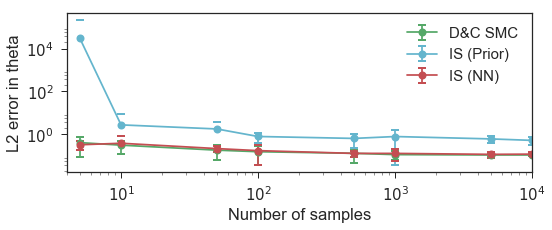

In [23]:
plt.figure(figsize=(8,3.5))

tmp_m, tmp_s = dcsmc_results_L2.mean(0), dcsmc_results_L2.std(0)
plt.errorbar(sizes, tmp_m, 2*tmp_s,marker='.', capsize=4, markeredgewidth=2, color=sns.color_palette()[1])

tmp_m, tmp_s = lwis_results_L2.mean(0), lwis_results_L2.std(0)
plt.errorbar(sizes, tmp_m, 2*tmp_s,marker='.', capsize=4, markeredgewidth=2,color=sns.color_palette()[5])

tmp_m, tmp_s = nnis_results_L2.mean(0), nnis_results_L2.std(0)
plt.errorbar(sizes, tmp_m, 2*tmp_s,marker='.', capsize=4, markeredgewidth=2, color=sns.color_palette()[2])

plt.legend(['D&C SMC', 'IS (Prior)', 'IS (NN)'], loc='upper right')
plt.loglog();

plt.xlim(sizes[0]-1, sizes[-1])

plt.ylabel("L2 error in theta")
plt.xlabel("Number of samples")
plt.tight_layout();

Note that the L2 error above is relative to the MCMC run, which is not authoratative.